# Problem Statement

#### In today’s world of automation, the skills and knowledge of a person could be utilized at the best places possible by automating tasks wherever possible. As a part of the hospital automation system, one can build a system that would predict and estimate whether the patient should be categorized as an incare patient or an outcare patient with the help of several data points about the patients, their conditions and lab tests.

###  Importing Necessary libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')  




### Importing Dataset

In [6]:
 data = pd.read_csv('patientdata.csv')

# About Data
The dataset contains Electronic Health Record predictions collected from a private Hospital in Indonesia. It contains the patient's laboratory test results used to determine the next patient's treatment whether <b>in care</b> or <b>out care.</b>

### Attribute information
- HAEMATOCRIT – Percentage of red blood cells in blood.
- HAEMOGLOBINS – Hemoglobin level in the blood.
- ERYTHROCYTE – Number of red blood cells.
- LEUCOCYTE – Number of white blood cells.
- THROMBOCYTE – Number of platelets.
- MCH – Mean Corpuscular Hemoglobin.
  - Measures the average amount of hemoglobin in a single red blood cell.
  - Low MCH → May indicate iron deficiency anemia.
  - High MCH → May suggest macrocytic anemia (e.g., due to Vitamin B12 or folate deficiency).


- MCHC – Mean Corpuscular Hemoglobin Concentration.
- MCV – Mean Corpuscular Volume.
- AGE – Patient's age.
- SEX – Gender (M/F).
- SOURCE – Whether the patient is an outpatient ("out") or inpatient ("in").

#### Acknowledgements
This dataset was originally downloaded from Mendeley Data.
Sadikin, Mujiono (2020), “EHR Dataset for Patient Treatment Classification”, Mendeley Data, V1, doi: 10.17632/7kv3rctx7m.1<br>

In [7]:
data.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310.0,25.4,33.6,75.5,1.0,F,out
1,43.5,NaN,5.39,12.7,334.0,27.5,34.0,80.7,1.0,F,out
2,33.5,11.3,4.74,13.2,305.0,23.8,33.7,70.7,1.0,F,out
3,39.1,13.7,4.98,10.5,366.0,27.5,35.0,78.5,1.0,F,out
4,30.9,9.9,4.23,22.1,333.0,23.4,32.0,73.0,1.0,M,out


In [8]:
data.shape

(4412, 11)

In [9]:
data.columns

Index(['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE',
       'THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX', 'SOURCE'],
      dtype='object')

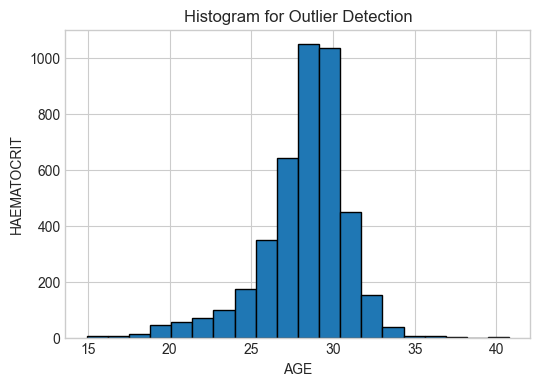

In [10]:
plt.figure(figsize=(6, 4))
plt.hist(data["MCH"], bins=20, edgecolor="black") 
plt.title("Histogram for Outlier Detection")
plt.xlabel("AGE")
plt.ylabel("HAEMATOCRIT")
plt.show()

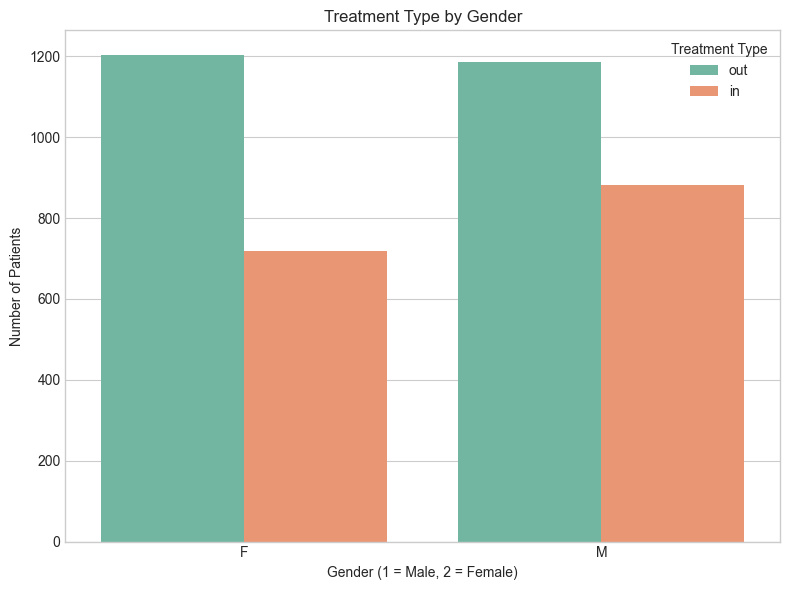

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='SEX', hue='SOURCE', palette='Set2')


plt.title('Treatment Type by Gender')
plt.xlabel('Gender (1 = Male, 2 = Female)')
plt.ylabel('Number of Patients')
plt.legend(title='Treatment Type')
plt.tight_layout()


plt.show()

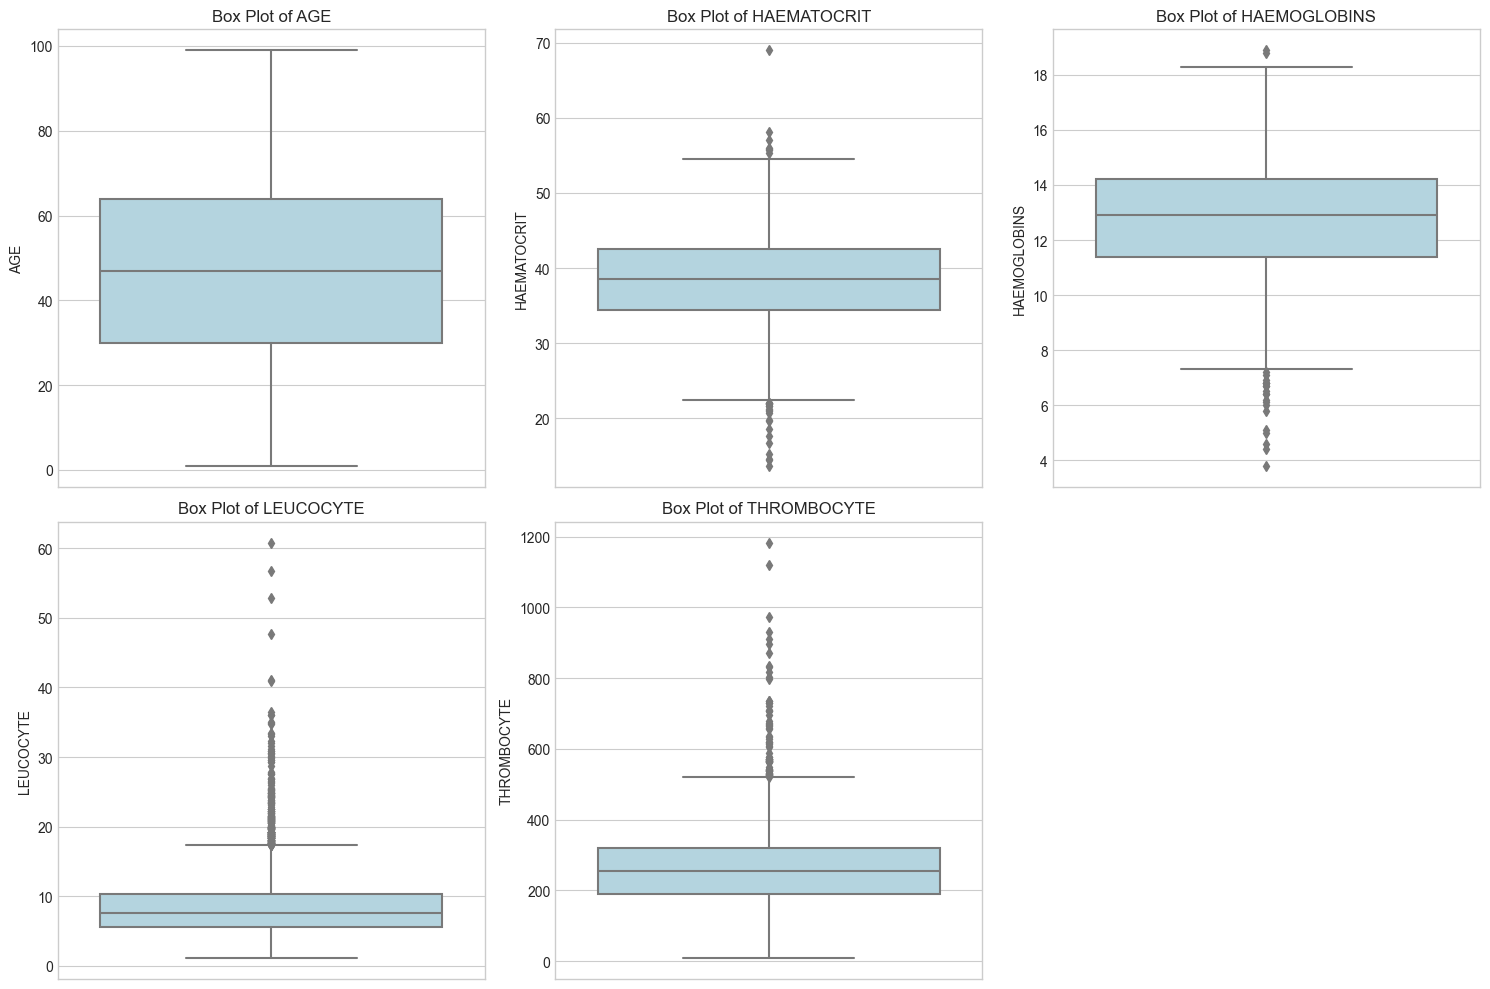

In [12]:
features = ['AGE', 'HAEMATOCRIT', 'HAEMOGLOBINS', 'LEUCOCYTE', 'THROMBOCYTE']

# Create a figure with subplots
plt.figure(figsize=(15, 10))

# Generate box plots for each feature
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[feature].dropna(), color='lightblue')
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

# Exploratory Data Analysis

In [13]:
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns")

The dataset contains 4412 rows and 11 columns


In [14]:
features = [col for col in data.columns if col != 'SOURCE']  # Get all column names
numerical_features = [feat for feat in features if data[feat].dtype != object]
categorical_features = [feat for feat in features if data[feat].dtype == object]

print(f"Total number of features : {len(features)}")
print(f"Number of numerical features : {len(numerical_features)}")
print(f"Number of categorical features : {len(categorical_features)}\n")

Total number of features : 10
Number of numerical features : 9
Number of categorical features : 1



## Checking Null values

## Handling Null values

In [15]:
data.isna().mean().to_frame(name="Missing %")

,Missing %
HAEMATOCRIT,0.044424
HAEMOGLOBINS,0.051451
ERYTHROCYTE,0.051451
LEUCOCYTE,0.044198
THROMBOCYTE,0.048051
MCH,0.049637
MCHC,0.049637
MCV,0.050544
AGE,0.048504
SEX,0.050997


In [16]:

for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:  
        data[col] = data[col].fillna(data[col].median())  # Using median for numerical columns
    else:
        data[col] = data[col].fillna(data[col].mode()[0])  # Using mode for categorical columns


print(data.isna().sum())


HAEMATOCRIT     0
HAEMOGLOBINS    0
ERYTHROCYTE     0
LEUCOCYTE       0
THROMBOCYTE     0
MCH             0
MCHC            0
MCV             0
AGE             0
SEX             0
SOURCE          0
dtype: int64


In [17]:
# Removing outliers beyond 1.5 * IQR
# Define numerical columns
numerical_cols = data.select_dtypes(include=['float64']).columns
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]


In [18]:
# Rechecking outliers after handling
Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Counting outliers
remaining_outliers = ((data[numerical_cols] < (Q1 - 1.5 * IQR)) | (data[numerical_cols] > (Q3 + 1.5 * IQR))).sum()
print(remaining_outliers)


HAEMATOCRIT     25
HAEMOGLOBINS    16
ERYTHROCYTE     29
LEUCOCYTE       73
THROMBOCYTE     23
MCH             37
MCHC            49
MCV              6
AGE              0
dtype: int64


In [19]:
data['SOURCE'] = data['SOURCE'].fillna(data['SOURCE'].mode()[0])  


In [20]:
data.nunique().to_frame(name="# of unique values")

,# of unique values
HAEMATOCRIT,272
HAEMOGLOBINS,101
ERYTHROCYTE,333
LEUCOCYTE,156
THROMBOCYTE,452
MCH,99
MCHC,49
MCV,243
AGE,94
SEX,2


# Label Encoding

In [21]:
data['SOURCE'] = data.SOURCE.replace({"in":1,"out":0}) 

In [22]:
data.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310.0,25.4,33.6,75.5,1.0,F,0
1,43.5,12.9,5.39,12.7,334.0,27.5,34.0,80.7,1.0,F,0
3,39.1,13.7,4.98,10.5,366.0,27.5,35.0,78.5,1.0,F,0


# Split the data 
### Train: 80% of data
### Test: 20% of data

In [23]:
# get all the features
features = [feat for feat in data.columns if feat !='SOURCE']

x=data[features] #feature set
y=data['SOURCE'] #target

# Splitting the data into training and testing
x_train,x_test,y_train,y_test, = train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

#train and test dimensions
x_train.shape,x_test.shape


((2872, 10), (719, 10))

# Univariate Analysis

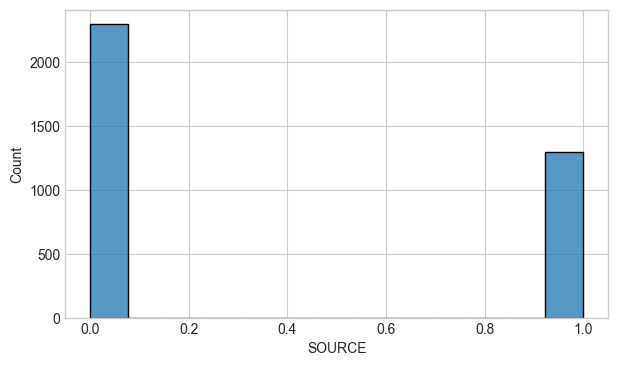

In [24]:
#Target Distribution

plt.figure(figsize=(7,4))
fig=sns.histplot(x='SOURCE',data=data)

In [25]:
# Check no. of data points for each class

data.SOURCE.value_counts().to_frame(name='Count')

,Count
0,2293
1,1298


### Numerical features
names :
- HAEMATOCRIT
- HAEMOGLOBINS
- ERYTHROCYTE
- LEUCOCYTE
- THROMBOCYTE
- MCH
- MCHC
- MCV
- AGE

In [26]:
data[numerical_features].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.000000,3591.00000
mean,38.962072,13.023392,4.563601,7.703509,247.996658,28.671707,33.459566,85.641270,45.91785
std,5.215079,1.818913,0.654357,3.131393,93.190050,1.742293,0.906628,4.656846,20.76473
min,23.500000,7.800000,2.770000,1.100000,15.000000,23.600000,31.100000,73.400000,1.00000
25%,35.900000,11.900000,4.170000,5.500000,193.000000,27.600000,32.900000,82.650000,30.00000
50%,39.000000,13.000000,4.570000,7.400000,256.000000,28.700000,33.400000,85.500000,47.00000
75%,42.650000,14.300000,5.005000,9.500000,308.000000,29.800000,34.000000,88.700000,62.00000
max,52.600000,17.900000,6.310000,16.700000,495.000000,33.400000,35.900000,97.900000,99.00000


# Box Plot

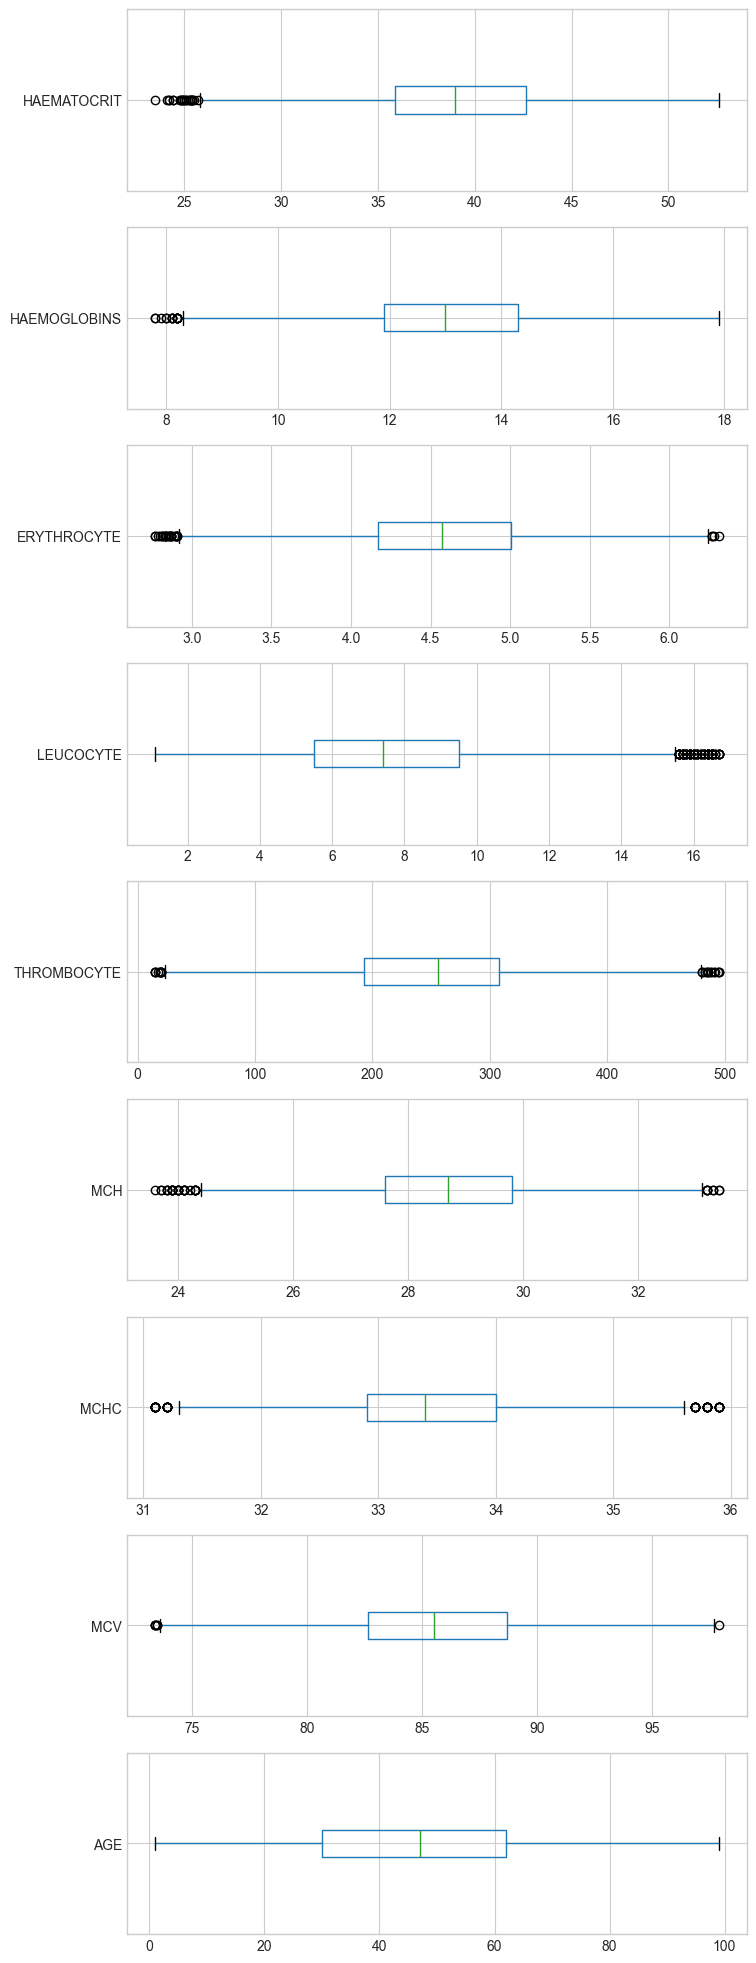

In [27]:
# Boxplot for each numerical feature
fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(numerical_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

# Density Plot

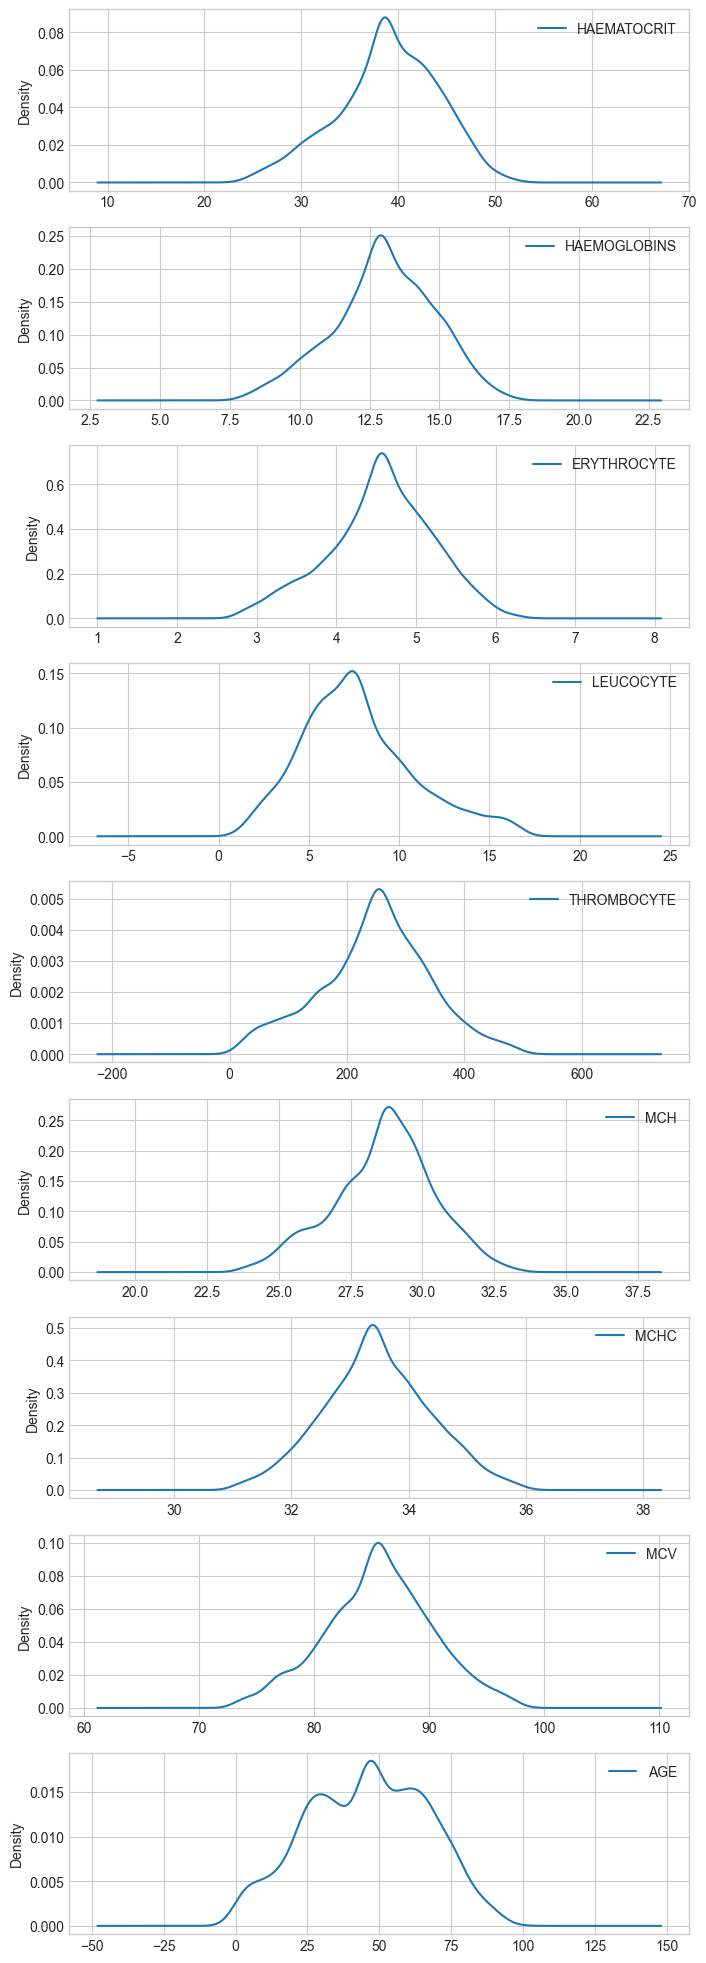

In [28]:
# Kernel Density plot for each numerical value

fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(numerical_features):
    f = data[[c]].plot(kind='kde',ax=axes[i])

Observations:
- Few outliers are present in some numerical features
- Most of the features follows the Gaussian distribution (approx.)

### Categorical features
name : SEX<br>
labels : F, M

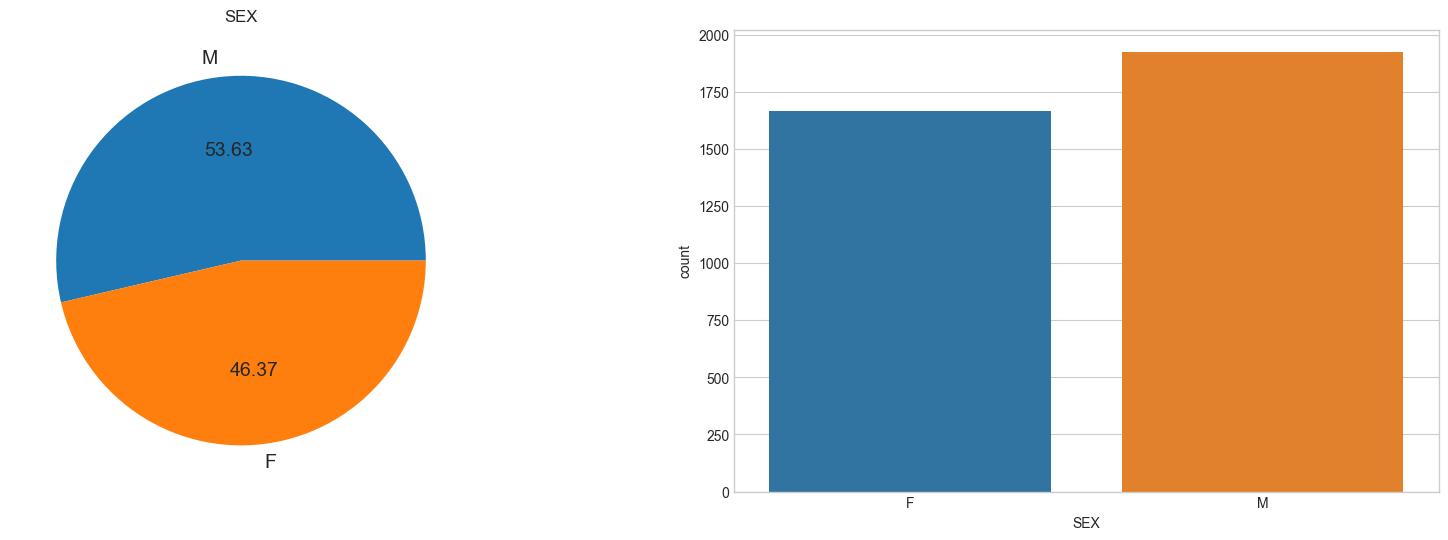

In [29]:
# Bar and count plot for Categorical feature
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
df = data['SEX'].value_counts()
barplot = df.plot(kind='pie', ax=axes[0], title='SEX', autopct="%.2f", fontsize=14, ylabel='')
countplot = sns.countplot(x='SEX', data=data, ax=axes[1])

# Bivariate analysis

### Numerical features

#### KDE plot

In [30]:
num_features = numerical_features

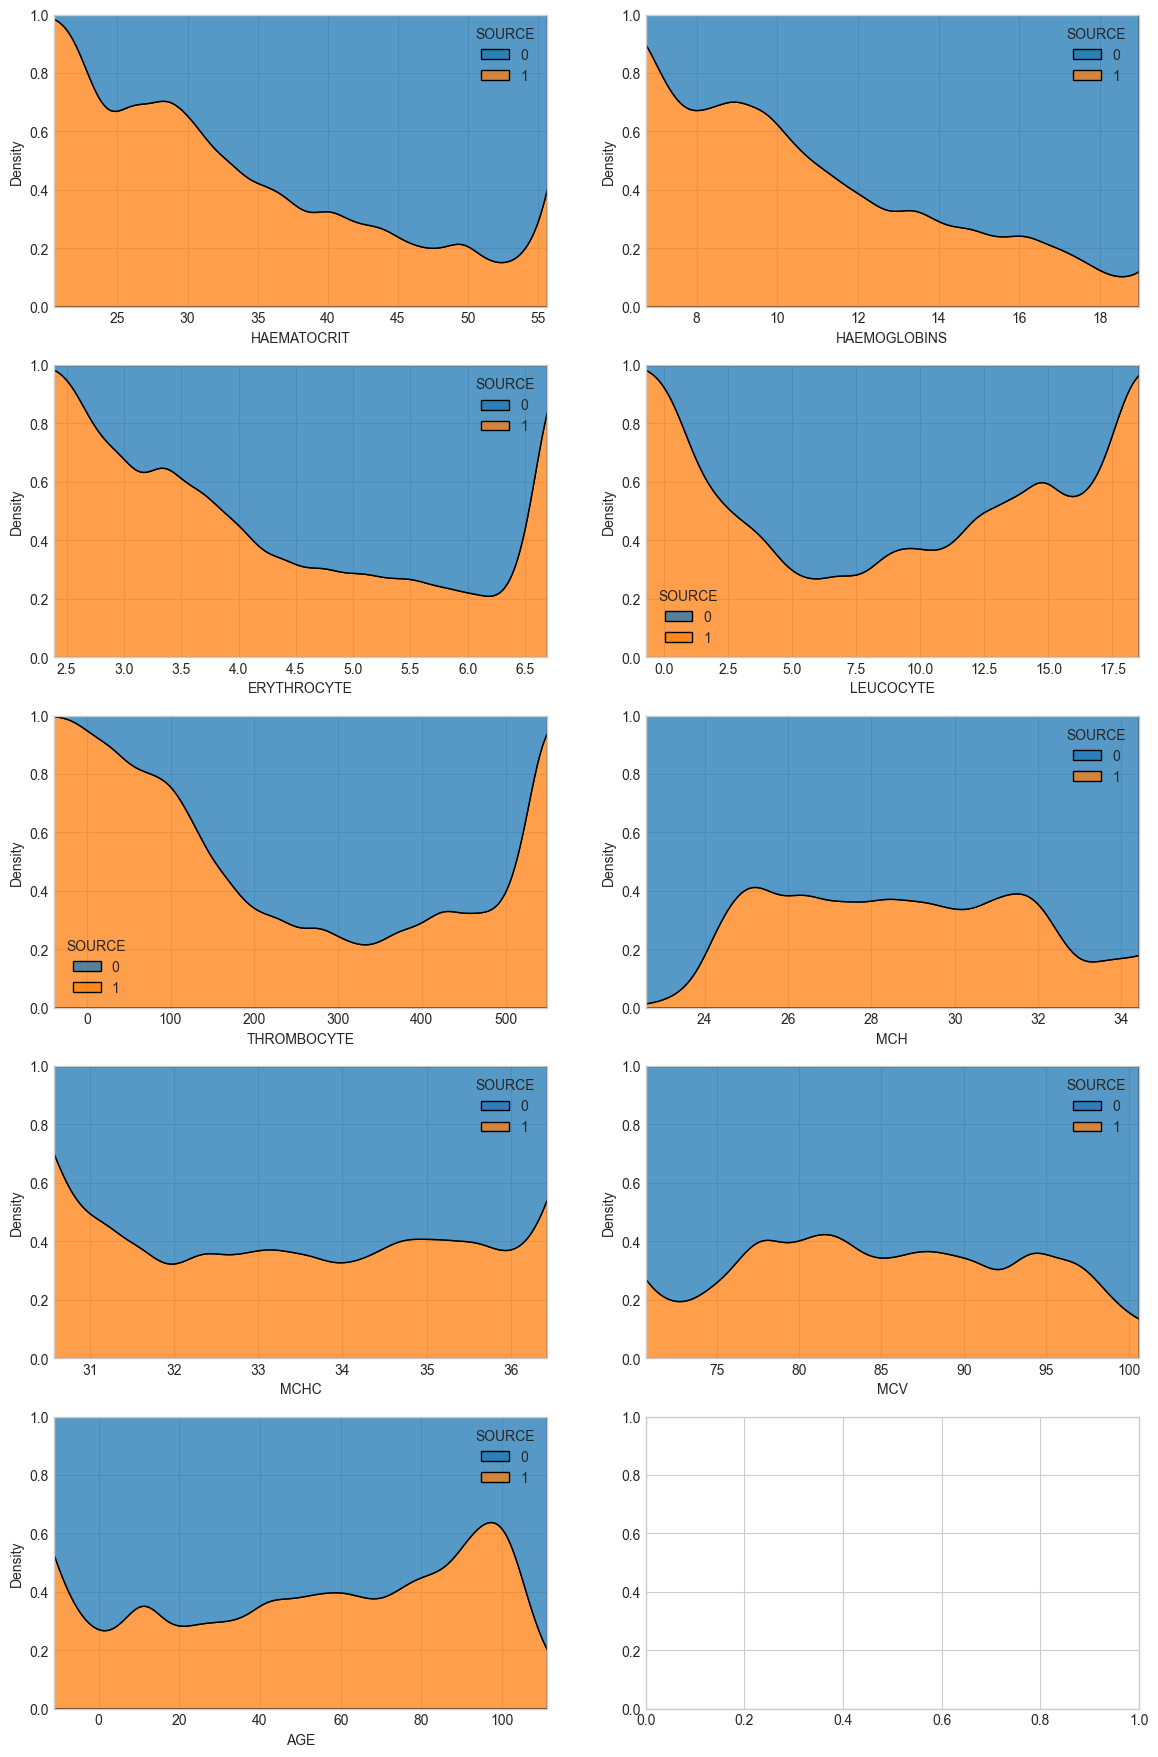

In [31]:
# KDEplot for each numerical feature w.r.t target
#KDE = Kernal Density Estimation
fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    plot = sns.kdeplot(data=data, x=c, hue='SOURCE', multiple='fill', ax=axes[i])

#### Bar plot

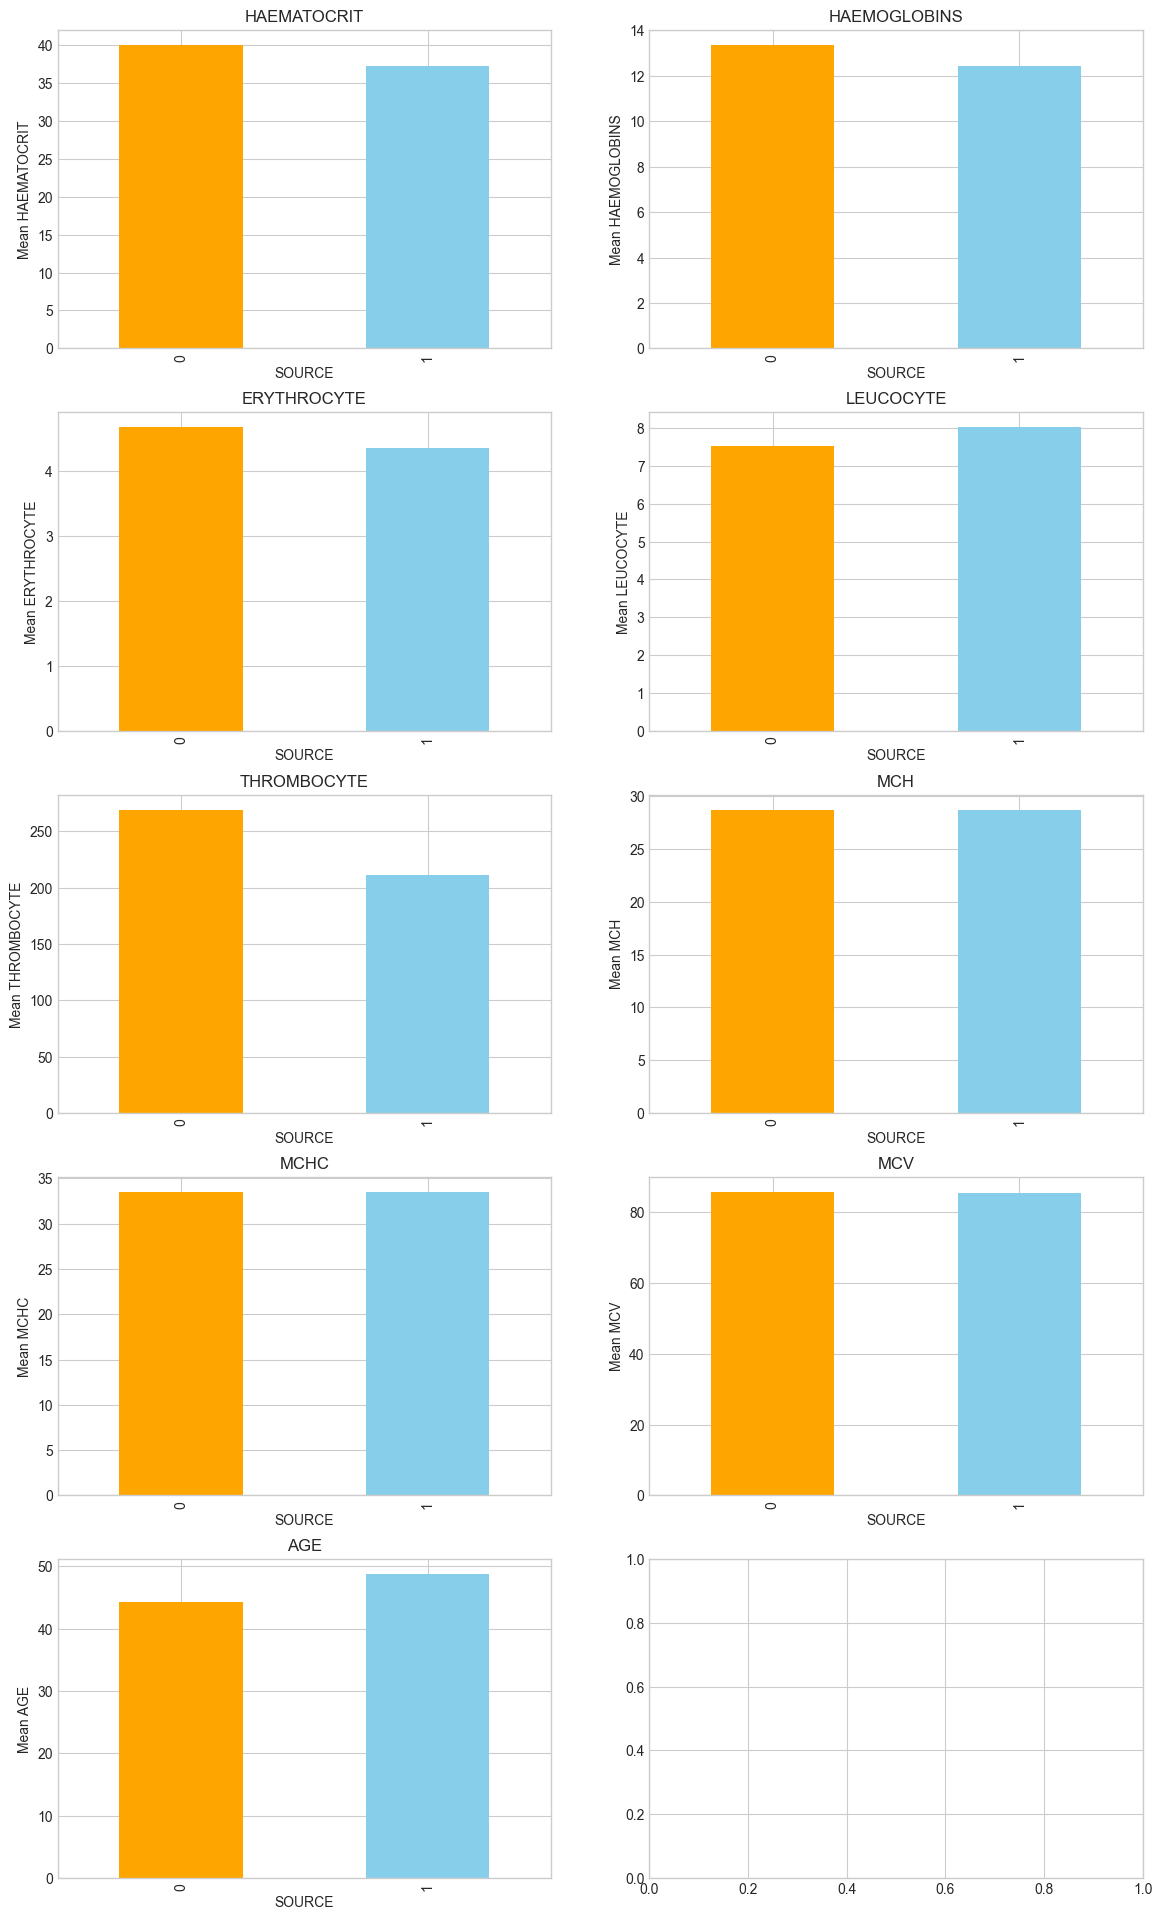

In [32]:
# Relationship between target and mean of each numerical features

fig, axes = plt.subplots(5,2, figsize=(14,24))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    df = data.groupby("SOURCE")[c].mean()
    plot = df.plot(kind='bar', title=c, ax=axes[i], ylabel=f'Mean {c}', color=('orange','skyblue'))

Observations:
- On average, The quantity of HAEMOTOCRIT, HAEMOGLOBINS, ERYTHROCYTE, and THROMBOCYTE features are lesser in In care patients.
- MCH, MCHV, MCV are less informative to differentiate classes
- The mean age of Incare patients is greater than the Outcare patients.

#### Correlation - matrix

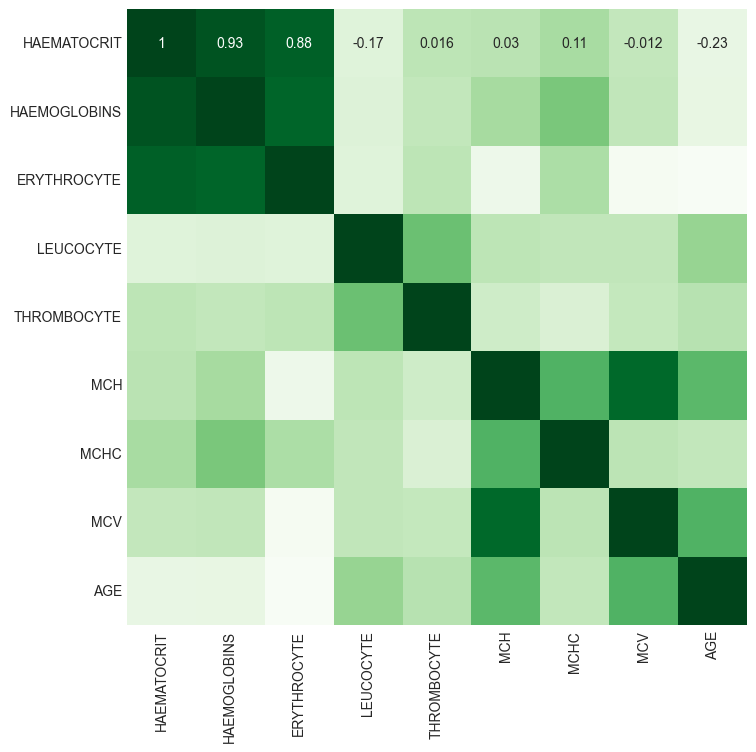

In [33]:
corr_matt = data[num_features].corr(method='pearson')
plt.figure(figsize=(8,8))
corr = sns.heatmap(corr_matt, annot=True, cmap='Greens', cbar=False)

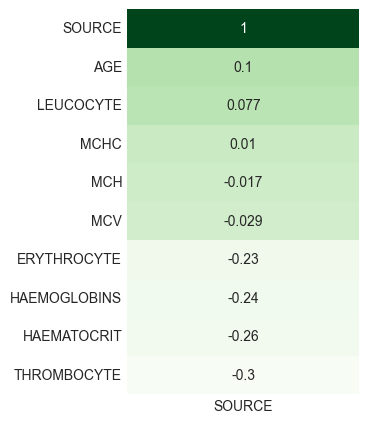

In [34]:
corr_matt = data.corr(method='pearson')[['SOURCE']].sort_values(by='SOURCE',ascending=False)
plt.figure(figsize=(3,5))
corr = sns.heatmap(corr_matt, annot=True, cmap='Greens', cbar=False)

Observations:
- LEUCOCYTE and AGE are postively correlated with target
- THROMBOCYTE, ERYTHROCYTE, HAEMOGLOBINS and HAEMATOCRIT are negatively correlated with target
- No notable correlation found between MCHC, MCH, MCV, and target

### Categorical features

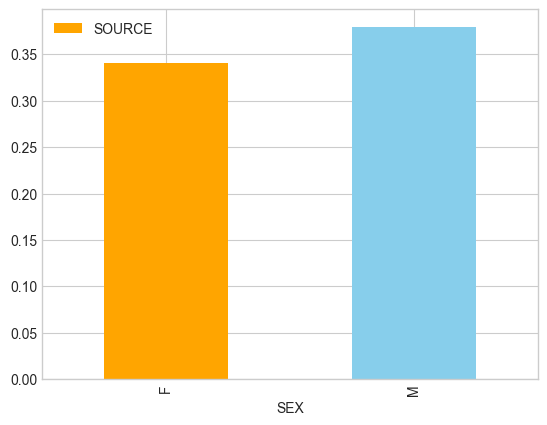

In [35]:
# Mean of target==1 w.r.t SEX

df = data.groupby('SEX')['SOURCE'].mean().to_frame().reset_index()
plot = df.plot(kind='bar', x='SEX', y='SOURCE', color=('orange', 'skyblue'))

Observation:
- Male Incare patients are more in number than Female Incare patients

# Feature Engineering 

### Label Encoding

In [36]:
x_train.SEX.replace({"F":0,"M":1},inplace=True)
x_test.SEX.replace({"F":0,"M":1},inplace=True)

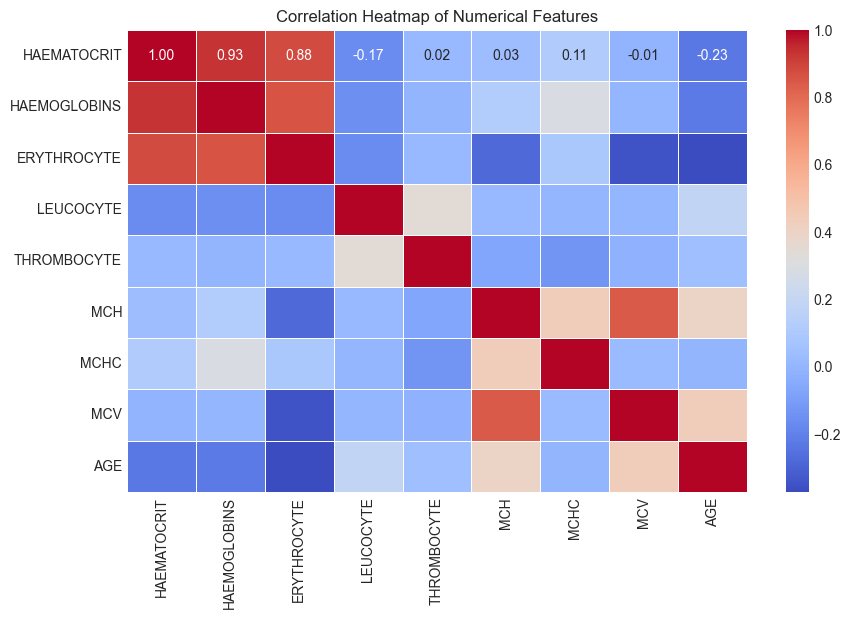

In [37]:
# Compute correlation matrix
correlation_matrix = data[numerical_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [38]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()


data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


data.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,0.398625,0.396040,0.531073,0.333333,0.614583,0.183673,0.520833,0.085714,0.0,F,0
1,0.687285,0.504950,0.740113,0.743590,0.664583,0.397959,0.604167,0.297959,0.0,F,0
3,0.536082,0.584158,0.624294,0.602564,0.731250,0.397959,0.812500,0.208163,0.0,F,0
5,0.371134,0.376238,0.497175,0.352564,0.354167,0.204082,0.562500,0.093878,0.0,M,0
7,0.577320,0.544554,0.553672,0.448718,0.504167,0.459184,0.395833,0.481633,0.0,F,0


In [39]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()


data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


data.head()


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,-0.740662,-0.672689,0.132055,-0.448268,0.665436,-1.878079,0.154919,-2.178015,-2.163481,F,0
1,0.870276,-0.067848,1.263095,1.595835,0.923010,-0.672602,0.596176,-1.061224,-2.163481,F,0
3,0.026452,0.372037,0.636438,0.893175,1.266442,-0.672602,1.699317,-1.533713,-2.163481,F,0
5,-0.894085,-0.782660,-0.051356,-0.352451,-0.676096,-1.763271,0.375547,-2.135062,-2.163481,M,0
7,0.256586,0.152095,0.254330,0.126636,0.096626,-0.328181,-0.506966,-0.094770,-2.163481,F,0


In [40]:
from sklearn.preprocessing import RobustScaler


scaler = RobustScaler()


data[numerical_cols] = scaler.fit_transform(data[numerical_cols])


data.head()


,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,-0.577778,-0.500000,0.095808,-0.275,0.469565,-1.500000,0.181818,-1.652893,-1.4375,F,0
1,0.666667,-0.041667,0.982036,1.325,0.678261,-0.545455,0.545455,-0.793388,-1.4375,F,0
3,0.014815,0.291667,0.491018,0.775,0.956522,-0.545455,1.454545,-1.157025,-1.4375,F,0
5,-0.696296,-0.583333,-0.047904,-0.200,-0.617391,-1.409091,0.363636,-1.619835,-1.4375,M,0
7,0.192593,0.125000,0.191617,0.175,0.008696,-0.272727,-0.363636,-0.049587,-1.4375,F,0


In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train[num_features] = scaler.fit_transform(x_train[num_features]) #fit and transform the train set
x_test[num_features] = scaler.transform(x_test[num_features]) #transform the test test

In [42]:
x_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX
1322,0.532646,0.495050,0.553672,0.314103,0.766667,0.357143,0.354167,0.371429,0.326531,0
1638,0.594502,0.613861,0.573446,0.448718,0.585417,0.571429,0.479167,0.473469,0.377551,1
3799,0.525773,0.514851,0.381356,0.262821,0.266667,0.816327,0.500000,0.848980,0.714286,1


In [43]:
x_train.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)
x_test.drop(['MCH', 'MCHC','MCV'], axis=1, inplace=True)

# final train set
x_train.head(3)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,AGE,SEX
1322,0.532646,0.495050,0.553672,0.314103,0.766667,0.326531,0
1638,0.594502,0.613861,0.573446,0.448718,0.585417,0.377551,1
3799,0.525773,0.514851,0.381356,0.262821,0.266667,0.714286,1


# Machine Learning

### Decision tree classifier

In [44]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(x_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, tree.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, tree.predict(x_test)))

Train accuracy :  1.0
Test accuracy :  0.6356050069541029


#### Hyperparameter tuning of Decision tree classifier

In [45]:
distribution = {'max_depth': [4, 6, 8, 10, 12, 14, 16],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': [2, 10, 20, 30, 40],
                'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                'max_leaf_nodes': [8, 16, 32, 64, 128,256],
                'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
               }
search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1),
                         distribution,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)
search.fit(x_train, y_train)
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'min_samples_split': 2,
 'max_leaf_nodes': 8,
 'max_features': 0.6,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 2}}

In [46]:
best_tree = search.best_estimator_
best_tree.fit(x_train, y_train)
print(" Best train accuracy : ", accuracy_score(y_train, best_tree.predict(x_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_tree.predict(x_test)))

 Best train accuracy :  0.721100278551532
 Best test accuracy :  0.7023643949930459


In [47]:
print(classification_report(y_test, best_tree.predict(x_test)))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       459
           1       0.58      0.66      0.62       260

    accuracy                           0.70       719
   macro avg       0.68      0.69      0.69       719
weighted avg       0.71      0.70      0.71       719



## Logistic regression

In [48]:
logreg = LogisticRegression()

logreg.fit(x_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, logreg.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, logreg.predict(x_test)))

Train accuracy :  0.7322423398328691
Test accuracy :  0.7440890125173852


#### Hyperparameter tuning for Logistic regression

In [49]:
# Hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'fit_intercept':[True, False],
              'max_iter':[100, 200, 300],
              'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 5}]
             }

# Random search for best hyperparameters
search = RandomizedSearchCV(LogisticRegression(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(x_train, y_train)

# Best parameters for Logistic regression classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'penalty': 'none',
 'max_iter': 300,
 'fit_intercept': True,
 'class_weight': {0: 1, 1: 1},
 'C': 0.01}

In [50]:
# Retrain with best model

best_logreg = search.best_estimator_

best_logreg.fit(x_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_logreg.predict(x_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_logreg.predict(x_test)))

Best train accuracy :  0.7308495821727019
Best test accuracy :  0.741307371349096


In [51]:
print(classification_report(y_test, best_logreg.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       459
           1       0.70      0.50      0.58       260

    accuracy                           0.74       719
   macro avg       0.73      0.69      0.70       719
weighted avg       0.74      0.74      0.73       719



## Support vector classifier

In [52]:
svc = SVC(random_state=1)

svc.fit(x_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, svc.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, svc.predict(x_test)))

Train accuracy :  0.7600974930362117
Test accuracy :  0.7649513212795549


#### Hyperparameter tuning - Support vector classifier

In [53]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree':[0, 1, 2, 3, 4, 5, 6]
             } 
search = RandomizedSearchCV(SVC(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)
search.fit(x_train, y_train)
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'kernel': 'rbf', 'gamma': 1, 'degree': 4, 'C': 100}

In [54]:
# Retrain with best model

best_svc = search.best_estimator_

best_svc.fit(x_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_svc.predict(x_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_svc.predict(x_test)))

Best train accuracy :  0.775766016713092
Best test accuracy :  0.7566063977746871


In [55]:
print(classification_report(y_test, best_svc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83       459
           1       0.74      0.50      0.60       260

    accuracy                           0.76       719
   macro avg       0.75      0.70      0.71       719
weighted avg       0.75      0.76      0.74       719



## Random Forest Classifier

In [56]:
forest = RandomForestClassifier(random_state=1)
forest.fit(x_train, y_train)
print("Train accuracy : ", accuracy_score(y_train, forest.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, forest.predict(x_test)))

Train accuracy :  1.0
Test accuracy :  0.7579972183588317


#### Hyperparameter tuning - Random forest classifier

In [57]:
params_grid = {'bootstrap': [True, False],
             'max_depth': [2, 5, 10, 20, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [50, 100, 150, 200]}
search = RandomizedSearchCV(RandomForestClassifier(random_state=1),
                         params_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=20)

search.fit(x_train, y_train)
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [58]:
best_forest = search.best_estimator_
best_forest.fit(x_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_forest.predict(x_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_forest.predict(x_test)))

Best train accuracy :  0.8955431754874652
Best test accuracy :  0.7635605006954103


In [59]:
print(classification_report(y_test, best_forest.predict(x_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       459
           1       0.72      0.56      0.63       260

    accuracy                           0.76       719
   macro avg       0.75      0.72      0.73       719
weighted avg       0.76      0.76      0.76       719



## Stacking Classifier
Combining all the best models

In [60]:
stack = StackingClassifier(estimators=[('best tree classifier', best_tree),
                                       ('best logreg', best_logreg),
                                       ('best svc', best_svc),
                                       ('best forest classifier', best_forest)],
                           
                           final_estimator=LogisticRegression(),
                           passthrough=True)

stack.fit(x_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, stack.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, stack.predict(x_test)))

Train accuracy :  0.8366991643454039
Test accuracy :  0.760778859527121


In [61]:
print(classification_report(y_test, stack.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.88      0.83       459
           1       0.73      0.54      0.62       260

    accuracy                           0.76       719
   macro avg       0.75      0.71      0.72       719
weighted avg       0.76      0.76      0.75       719



# Gaussian Navie Bayes Model

In [62]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, nb.predict(x_train)))
print("Test accuracy : ", accuracy_score(y_test, nb.predict(x_test)))

distribution = {'var_smoothing': [1e-1, 1e-3, 1e-5, 1e-7, 1e-9]}

search = RandomizedSearchCV(GaussianNB(),
                         distribution,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=5)

search.fit(x_train, y_train)
search.best_params_

best_nb = search.best_estimator_
best_nb.fit(x_train, y_train)
print(" Best train accuracy : ", accuracy_score(y_train, best_nb.predict(x_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_nb.predict(x_test)))
print(classification_report(y_test, best_nb.predict(x_test)))

Train accuracy :  0.7249303621169917
Test accuracy :  0.7204450625869263
Fitting 3 folds for each of 5 candidates, totalling 15 fits
 Best train accuracy :  0.7249303621169917
 Best test accuracy :  0.7204450625869263
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       459
           1       0.64      0.52      0.57       260

    accuracy                           0.72       719
   macro avg       0.70      0.68      0.68       719
weighted avg       0.71      0.72      0.71       719



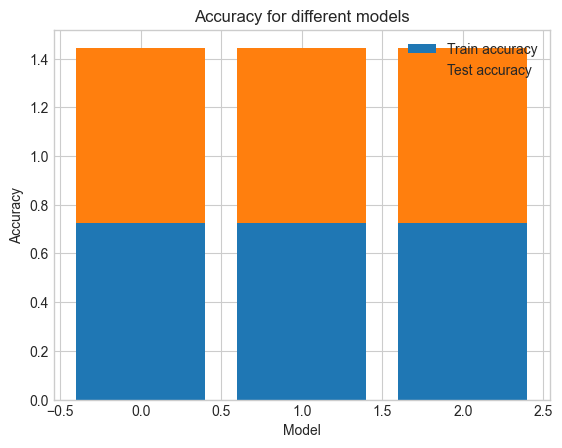

In [63]:
import matplotlib.pyplot as plt

# Get the accuracy scores for the different models
train_accuracy = [accuracy_score(y_train, nb.predict(x_train)),
                  accuracy_score(y_train, search.predict(x_train)),
                  accuracy_score(y_train, best_nb.predict(x_train))]
test_accuracy = [accuracy_score(y_test, nb.predict(x_test)),
                accuracy_score(y_test, search.predict(x_test)),
                accuracy_score(y_test, best_nb.predict(x_test))]

# Create the bar plot
plt.bar(range(len(train_accuracy)), train_accuracy, label='Train accuracy')
plt.bar(range(len(train_accuracy)), test_accuracy, bottom=train_accuracy, label='Test accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for different models')
plt.legend()
plt.show()

# KNN Classifier

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Define the hyperparameter distribution
param_dist = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(knn, param_dist, cv=3, scoring='accuracy', verbose=1, n_iter=5, random_state=1)

# Fit the model to the training data
search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", search.best_params_)

# Fit the best model to the training data
best_knn = search.best_estimator_

# Print the accuracy of the best model
print(" Best train accuracy : ", accuracy_score(y_train, best_knn.predict(x_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_knn.predict(x_test)))
print(classification_report(y_test, best_knn.predict(x_test)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 11}
 Best train accuracy :  0.7726323119777159
 Best test accuracy :  0.7524339360222532
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       459
           1       0.70      0.54      0.61       260

    accuracy                           0.75       719
   macro avg       0.74      0.71      0.72       719
weighted avg       0.75      0.75      0.74       719



## Gradient Boost classifer

In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

# Define hyperparameter distribution
param_dist = {'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [50, 100, 200, 500],
              'max_depth': [1, 3, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(gbc, param_dist, cv=3, scoring='accuracy', verbose=1, random_state=1, n_iter=5)

# Fit the model to the training data
search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", search.best_params_)

# Fit the best model to the training data
best_gbc = search.best_estimator_

# Print the accuracy of the best model
print(" Best train accuracy : ", accuracy_score(y_train, best_gbc.predict(x_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_gbc.predict(x_test)))
print(classification_report(y_test, best_gbc.predict(x_test)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.01}
 Best train accuracy :  0.8391364902506964
 Best test accuracy :  0.7552155771905424
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       459
           1       0.75      0.48      0.59       260

    accuracy                           0.76       719
   macro avg       0.75      0.70      0.71       719
weighted avg       0.75      0.76      0.74       719



## MLP classifer

In [66]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# Initialize MLP Classifier
mlp = MLPClassifier()

# Define hyperparameter distribution
param_dist = {'hidden_layer_sizes': [(50,), (100,), (150,)],
              'activation': ['tanh', 'relu'],
              'solver': ['lbfgs', 'sgd', 'adam'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling', 'adaptive']}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(mlp, param_dist, cv=3, scoring='accuracy', verbose=1, random_state=1, n_iter=5)

# Fit the model to the training data
search.fit(x_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", search.best_params_)

# Fit the best model to the training data
best_mlp = search.best_estimator_

# Print the accuracy of the best model
print(" Best train accuracy : ", accuracy_score(y_train, best_mlp.predict(x_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_mlp.predict(x_test)))
print(classification_report(y_test, best_mlp.predict(x_test)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
 Best train accuracy :  0.7496518105849582
 Best test accuracy :  0.7621696801112656
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       459
           1       0.73      0.54      0.62       260

    accuracy                           0.76       719
   macro avg       0.75      0.71      0.72       719
weighted avg       0.76      0.76      0.75       719



## Save the final pipeline

In [67]:
# final features
features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE', 'SEX']
num_features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE']

X = data[features] # feature set
y = data['SOURCE'] # target

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Label encoding
x_train.SEX.replace({'M':1, 'F':0}, inplace=True)
x_test.SEX.replace({'M':1, 'F':0}, inplace=True)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))

x_train[num_features] = scaler.fit_transform(x_train[num_features])
x_test[num_features] = scaler.transform(x_test[num_features])

# Train the final model again!
model = StackingClassifier(estimators=[('best tree classifier', best_tree),
                                       ('best logreg', best_logreg),
                                       ('best svc', best_svc),
                                       ('best forest classifier', best_forest)],
                           
                           final_estimator=LogisticRegression(),
                           passthrough=True)

model.fit(x_train, y_train)
print("Final model trained Successfully!")

# Pickle scaler object
with open("scaler.pkl", 'wb') as file:
    pickle.dump(scaler, file)
    
# Pickle model object
with open("model.pkl", 'wb') as file:
    pickle.dump(model, file)

print("Pickled and Saved Successfully!")

Final model trained Successfully!
Pickled and Saved Successfully!


### --------------------------- THE END ----------------------------